In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import skmob
import osmnx as ox
import mobair

# T-drive dataset: Taxis' trajectories

We will use data on taxis' trajectories in Beijing, China, that are freely available at https://www.microsoft.com/en-us/research/publication/t-drive-driving-directions-based-on-taxi-trajectories/ (by clicking on _Download the Trajectory Data_).

However, as the entire dataset is quite big (~15 millions points describing the trajectories of more than 10.000 vehicles moving in Beijing, China, within a week), we will use just a small sample in order to speed up our computations.

In [3]:
tdf = skmob.TrajDataFrame.from_file('./data/public/t-drive_sample_300.csv', latitude='lat', longitude='lon', user_id='uid', datetime='datetime')

print('Num. of points: ', tdf.shape[0])
print('Num. of vehicles: ', len(set(tdf.uid)))
print('Time interval: ', max(tdf['datetime'])-min(tdf['datetime']))
print('')
print(tdf.head())

Num. of points:  399367
Num. of vehicles:  299
Time interval:  6 days 04:08:02

   uid            datetime        lng       lat
0   73 2008-02-02 13:37:47  116.43275  39.84481
1   73 2008-02-02 13:38:32  116.42893  39.84520
2   73 2008-02-02 13:43:33  116.42629  39.85589
3   73 2008-02-02 13:47:51  116.41862  39.85676
4   73 2008-02-02 13:48:35  116.41738  39.85652


# Preprocessing

### Noise filtering
A straightforward way of identifying and filtering out outliers is to compute the instantaneous speed of the user in each of the points composing its trajectory, and filter out those points whose value of speed is unreliable (e.g. speed > 300 $km/h$).

In [4]:
from skmob.preprocessing import filtering

ftdf = filtering.filter(tdf, max_speed_kmh=300)

print('%s points removed.' %(len(tdf)-len(ftdf)))

32254 points removed.


### Compression
We can spatially __cluster__ the points that are closer than, e.g., 50 meters from each other, in order to reduce the number of points forming the trajectories. This can be particularly useful for the next step, usually named _stop detection_.

In [5]:
from skmob.preprocessing import compression

# compress the trajectory using a spatial radius of 50m
ctdf = compression.compress(ftdf, spatial_radius_km=0.05)

### Stops detection

Identifying the __stop locations__ (or _stay points_) in an important step in trajectory data mining, as it let us make some useful things like:
- _trajectory segmentation_, which consists in splitting the trajectories into sub-trajectories, thus identifying the different trips made by each user during the period;
- identification of the _semantic locations_, like Points-of-Interest, most frequented locations (in our case, the taxi stand, or the airport), etc.

We can identify the stop locations of each vehicle as the points where it spent at least `t` minutes within a certain radius `r` from it.

In the following example, `t = 10 minutes` and `r = 200 meters`.

In [6]:
from skmob.preprocessing import detection

stdf = detection.stops(ctdf, minutes_for_a_stop=10.0, spatial_radius_km=0.2, leaving_time=True)
print('Num. of stops: ', stdf.shape[0])
print(stdf.head())

Num. of stops:  21200
  uid            datetime         lng       lat    leaving_datetime
0   1 2008-02-02 16:36:08  116.456170  39.90531 2008-02-02 17:00:24
1   1 2008-02-02 17:10:24  116.506610  39.91450 2008-02-02 20:30:34
2   1 2008-02-02 21:10:33  116.595120  39.90798 2008-02-02 21:30:33
3   1 2008-02-02 21:40:33  116.691665  39.85169 2008-02-03 10:40:29
4   1 2008-02-03 11:20:28  116.516290  39.90905 2008-02-03 11:30:29


### Trajectory segmentation

We can use the identifyied stop locations of each vehicle to group the points into different sub-trajectories identifying trips occurring between different stop locations. 

In our case, each of these sub-trajectories will (hopefully) represent a single ride made by the taxi (with or without a passenger).

In [7]:
from mobair.utils import split_trajectories_in_tdf

# this should take ~30 seconds..
tdf_splitted = split_trajectories_in_tdf(ctdf, stdf)
print(tdf_splitted.head())

   uid            datetime        lng       lat  tid
0    1 2008-02-02 15:36:08  116.51172  39.92123    1
1    1 2008-02-02 15:46:08  116.51135  39.93883    1
2    1 2008-02-02 15:56:08  116.51627  39.91034    1
3    1 2008-02-02 16:06:08  116.47186  39.91248    1
4    1 2008-02-02 16:16:08  116.47217  39.92498    1


### Time filtering
An important last step of our preprocessing is a filtering of the trajectories in which we retain a trajectory only if:
- it is composed by at least 2 points,
- the distance between two consecutive points is not greater than a threshold (that we call ```max_interval``` here).

This is an important step because the densest the trajectories are, the more reliable the estimates of speed and acceleration and, by consequence, those of emissions, will be.

In [8]:
from mobair import filtering

max_interval = 120  # max time (in seconds) between two consecutive points of a trajectory

tdf_filtered_time = filtering.filter_on_time_interval(tdf_splitted, max_interval)

# Speed and acceleration computation

Here we compute the instantaneous speed and acceleration of the vehicle in each point of its trajectories, and filter out points in which we obtain unreliable values.

In [9]:
from mobair import speed

max_speed = 300
max_acc = 10

tdf_with_speed_and_acc = speed.compute_acceleration_from_tdf(tdf_filtered_time)

ftdf = tdf_with_speed_and_acc[(tdf_with_speed_and_acc['acceleration'] < max_acc) &
                              (tdf_with_speed_and_acc['acceleration'] > -max_acc) &
                              (tdf_with_speed_and_acc['speed'] < max_speed)]

# Matching with the road network

We place the points onto the road network in order to assign to each road the emissions it hosted during the period.

### 1. loading the road network
We use ```osmnx``` here to load the road network of a neighbourhood of Beijing in which our taxis move.

In [10]:
import osmnx as ox

# define the neighbourhood
region_name = 'Xicheng District, Beijing'

# loading the network
road_network = ox.graph_from_place(region_name, network_type='drive_service')

# the network type may be one of: 
# - 'drive' : get drivable public streets (but not service roads)
# - 'drive_service' : get drivable public streets, including service roads
# - 'walk' : get all streets and paths that pedestrians can use (this network type ignores one-way directionality)
# - 'bike' : get all streets and paths that cyclists can use
# - 'all' : download all (non-private) OSM streets and paths
# - 'all_private' : download all OSM streets and paths, including private-access ones

# saving the num. of edges
num_edges_dir = len(road_network.edges)

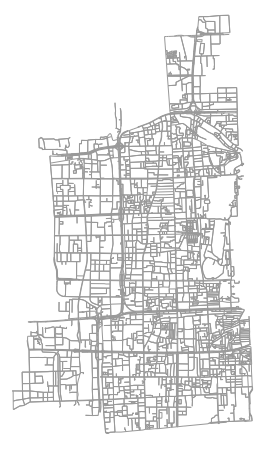

In [11]:
fig, ax = ox.plot_graph(road_network, bgcolor='white', node_size=0, edge_linewidth=1)

In [12]:
road_network = ox.get_undirected(road_network)

num_edges_undir = len(road_network.edges)
print('Num. of edges of the directed multigraph:', num_edges_dir)
print('Num. of edges of the undirected multigraph:', num_edges_undir)

Num. of edges of the directed multigraph: 10637
Num. of edges of the undirected multigraph: 6506


### Trajectory selection

Now, we need to select only the trajectories of the vehicles moving inside the chosen region.

In order to do it, we will use `scikit-mobility` to download a __tessellation__ over the region of interest, then map each point to its corresponding cell, and finally discarding points that fall outside the tessellation.

In [13]:
import warnings
warnings.filterwarnings('ignore')

In [14]:
# define the name of the region:
REGION = 'Xicheng District, Beijing'

## Now we can download the tessellation over the chosen region, after setting the desired size of its cells...
cell_size = 200  # the side of each cell in the tessellation (in meters)

from skmob.tessellation import tilers
tessellation = tilers.tiler.get("squared", base_shape=REGION, meters=cell_size)

## ... and then select the trajectories within the tessellation:
from mobair.utils import select_trajectories_within_tessellation

tdf_mapped = select_trajectories_within_tessellation(ftdf, tessellation)

print('Num. of points inside the region: ', tdf_mapped.shape[0])
print('Num. of vehicles: ', len(set(tdf_mapped.uid)))

Num. of points inside the region:  11073
Num. of vehicles:  193


### 3. Points snapping

Finally, we simply assign each point in our ```TrajdataFrame``` to its nearest edge (i.e. street) of the road network.

In [15]:
from mobair import mapmatching

tdf_final = mapmatching.find_nearest_edges_in_network(road_network, tdf_mapped, return_tdf_with_new_col=True)
print(tdf_final.head())

     uid            datetime        lng       lat  tid     speed  \
0      2 2008-02-02 13:37:16  116.37481  39.88782    1  0.000000   
1      2 2008-02-02 13:38:53  116.37677  39.88791    1  1.727076   
120    2 2008-02-03 10:11:59  116.37018  39.88805   61  0.000000   
121    2 2008-02-03 10:13:04  116.36677  39.88798   61  4.477609   
122    2 2008-02-03 10:32:06  116.35042  39.89179   62  0.000000   

     acceleration tile_ID                    road_link  
0        0.000000    1642   (340238739, 1598453917, 0)  
1        0.017805    1717  (1598453921, 1599483533, 0)  
120      0.000000    1429  (1598453922, 1598453929, 0)  
121      0.068886    1358   (322121800, 1598453923, 0)  
122      0.000000     769    (530642218, 734169796, 0)  


# Emissions' estimation

Our emissions' estimation step only needs the information on each vehicle's engine type (whether it is a "PETROL", "DIESEL", or "LPG" vehicle), and some emissions functions.

In this example, as we do not have the information about the real vehicles' engines, we arbitrarily set 75\% random taxis to be petrol vehicles, 20\% diesel, and 5\% LPG (Liquid Petroleum Gas).

In [16]:
## create the dictionary indicating the engine type for each vehicle
import numpy as np

set_uids = set(tdf_final.uid)
map__vehicle__fuel_type = {uid : np.random.choice(['PETROL', 'DIESEL', 'LPG'], 1, p=[0.75, 0.2, 0.05]).item() for uid in set_uids}

In [17]:
## loading the emissions functions
import pandas as pd

df_emissions = pd.read_csv('./data/private/emission_functions.csv')

In [18]:
## computing emissions
from mobair import emissions

tdf_with_emissions = emissions.compute_emissions(tdf_final, df_emissions, map__vehicle__fuel_type)
print(tdf_with_emissions.head())

     uid            datetime        lng       lat  tid     speed  \
0      2 2008-02-02 13:37:16  116.37481  39.88782    1  0.000000   
1      2 2008-02-02 13:38:53  116.37677  39.88791    1  1.727076   
120    2 2008-02-03 10:11:59  116.37018  39.88805   61  0.000000   
121    2 2008-02-03 10:13:04  116.36677  39.88798   61  4.477609   
122    2 2008-02-03 10:32:06  116.35042  39.89179   62  0.000000   

     acceleration tile_ID                    road_link      CO_2      NO_x  \
0        0.000000    1642   (340238739, 1598453917, 0)  0.553000  0.000619   
1        0.017805    1717  (1598453921, 1599483533, 0)  0.832964  0.000743   
120      0.000000    1429  (1598453922, 1598453929, 0)  0.553000  0.000619   
121      0.068886    1358   (322121800, 1598453923, 0)  1.293148  0.000924   
122      0.000000     769    (530642218, 734169796, 0)  0.553000  0.000619   

          VOC        PM  
0    0.004470  0.000000  
1    0.004471  0.000025  
120  0.004470  0.000000  
121  0.004473  0.0

## Visualising emissions onto the roads

We can use here ```Altair``` to plot the road network with each road colored with respect to the emissions it suffers.

In [19]:
import altair as alt
from altair_saver import save
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [20]:
df_emissions_per_road = tdf_with_emissions.groupby('road_link')['CO_2'].sum()

map__road__emissions = df_emissions_per_road.to_dict()

In [21]:
from mobair.utils import add_edge_emissions

road_network = add_edge_emissions(map__road__emissions, road_network, name_of_pollutant='CO_2')

In [22]:
from mobair import plot

plot.streetDraw(region_name, road_network, 'CO_2')

alt.LayerChart(...)